In [1]:
import sklearn as sk
import numpy as np
import pandas as pd
import os

from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords, wordnet

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix

from preprocessing import preprocess, create_dataframe_for_training
import re
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Embedding, LSTM, SpatialDropout1D, Bidirectional, Dropout, Concatenate, concatenate, Input
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dropout
from sklearn.model_selection import train_test_split

from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)

seed = 123
np.random.seed(seed)

PREPROCESSING = False
REMOVE_STOP_WORDS = False
THRESHOLD_INFREQUENT_WORDS = 0.01

C:\Anaconda\lib\site-packages\tensorflow\python\framework\dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Anaconda\lib\site-packages\tensorflow\python\framework\dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Anaconda\lib\site-packages\tensorflow\python\framework\dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Anaconda\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is depr

In [2]:
PROJECT_DIR = os.getcwd()
DATA_DIR = os.path.join(PROJECT_DIR, 'data')
DATA_FILEPATH = os.path.join(DATA_DIR, 'metadata_articles_dataframe.pkl')

data = pd.read_pickle(DATA_FILEPATH)
#data = data[:1000]

# X_train, y_train = data[data["fold"]=="train"].drop(columns="label"), data[data["fold"]=="train"]["label"]
# X_dev, y_dev = data[data["fold"]=="development"].drop(columns="label"), data[data["fold"]=="development"]["label"]
# X_test, y_test = data[data["fold"]=="test"].drop(columns="label"), data[data["fold"]=="test"]["label"]

# print("Training size: " + str(X_train.shape[0]))
# print("Development size: " + str(X_dev.shape[0]))
# print("Testing size: " + str(X_test.shape[0]))


# def generate_feature_matrix(X_train, X_dev, X_test, preprocessing=False, remove_stopwords=False, min_df=1):
#     if preprocessing:
#         X_train = preprocess(X_train, remove_stopwords)
#         X_dev = preprocess(X_dev, remove_stopwords)
#         X_test = preprocess(X_test, remove_stopwords)

#     X_train = create_dataframe_for_training(X_train)
#     X_dev = create_dataframe_for_training(X_dev)
#     X_test = create_dataframe_for_training(X_test)

#     vectorizer = CountVectorizer(min_df=min_df)
#     X_train_fe = vectorizer.fit_transform(X_train)
#     X_valid_fe = vectorizer.transform(X_dev)
#     X_test_fe = vectorizer.transform(X_test)

#     return X_train_fe.toarray(), X_valid_fe.toarray(), X_test_fe.toarray()


# X_train_fe, X_dev_fe, X_test_fe = generate_feature_matrix(X_train, X_dev, X_test,
#                                                           preprocessing=PREPROCESSING,
#                                                           remove_stopwords=REMOVE_STOP_WORDS,
#                                                           min_df=THRESHOLD_INFREQUENT_WORDS)
# X_modeling, y_modeling = np.append(X_train_fe, X_dev_fe, axis=0), np.append(y_train, y_dev, axis=0)

# print("Training feature matrix shape: " + str(X_train_fe.shape))
# print("Development feature matrix shape: " + str(X_dev_fe.shape))
# print("Testing feature matrix shape: " + str(X_test_fe.shape))

In [3]:
df = data.reset_index(drop=True)
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

def clean_text(text):
    """
        text: a string
        
        return: modified initial string
    """
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text. substitute the matched string in REPLACE_BY_SPACE_RE with space.
    text = BAD_SYMBOLS_RE.sub('', text) # remove symbols which are in BAD_SYMBOLS_RE from text. substitute the matched string in BAD_SYMBOLS_RE with nothing. 
    text = text.replace('x', '')
#    text = re.sub(r'\W+', '', text)
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # remove stopwors from text
    return text

df['article_content'] = df['article_content'].apply(clean_text)
df['article_content'] = df['article_content'].str.replace('\d+', '')

df['claim'] = df['claim'].apply(clean_text)
df['claim'] = df['claim'].str.replace('\d+', '')

df.loc[df['claimant'] == "", "claimant"] = "unknown"
df["num_related_articles"] = df["related_articles"].apply(lambda x: len(x))
df['num_date'] = pd.to_numeric(df['date'].dt.strftime("%Y%m%d"))

In [4]:
df.head()

,index,id,claim,claimant,date,label,related_articles,fold,article_content,num_related_articles,num_date
0,0,0,line george orwells novel predicts power smar...,unknown,2017-07-17,0,"[122094, 122580, 130685, 134765]",train,george orwell predicted almost years agoapr...,4,20170717
1,1,1,maine legislature candidate leslie gibson insu...,unknown,2018-03-17,2,"[106868, 127320, 128060]",development,republican criticized parkland students drops ...,3,20180317
2,2,4,yearold girl named alyssa carson trained nasa ...,unknown,2018-07-18,1,"[132130, 132132, 149722]",train,first person complete nasas passport program a...,3,20180718
3,3,5,author roald dahl penned open letter urging p...,unknown,2019-02-04,2,"[123254, 123418, 127464]",train,dangerous measles tweet march many parents thi...,3,20190204
4,4,6,comes fighting terrorism another thing know wo...,Hillary Clinton,2016-03-22,2,"[41099, 89899, 72543, 82644, 95344, 88361]",train,remarks counterterrorism stanford universitysl...,6,20160322


In [5]:
# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 15000
# Max N words in each complaint.
MAX_SEQUENCE_LENGTH = 1000

EMBEDDING_DIM = 100

tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(df['article_content'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

X = tokenizer.texts_to_sequences(df['article_content'].values)
X_article = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
X = tokenizer.texts_to_sequences(df['claim'].values)
X_claim = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
X_num_articles = df["num_related_articles"].to_numpy().reshape(-1,1)
X_claimant = pd.get_dummies(df['claimant']).values
X_date = df["num_date"].to_numpy().reshape(-1,1)

X_numeric = np.concatenate((X_num_articles, X_claimant, X_date), axis=1)
X_final = np.concatenate((X_article, X_claim, X_num_articles, X_claimant, X_date), axis=1)
print('Shape of data tensor:', X_final.shape)

Found 1131145 unique tokens.
Shape of data tensor: (15555, 5107)


In [6]:
Y = pd.get_dummies(df['label']).values
print('Shape of label tensor:', Y.shape)

Shape of label tensor: (15555, 3)


In [7]:
modeling_idx = np.where(np.logical_or(data["fold"] == "train", data["fold"] == "development"))
#dev_idx = np.where(data["fold"] == "development")
test_idx = np.where(data["fold"] == "test")

In [8]:
# define the sets of inputs
numeric_input = Input(shape=(X_numeric.shape[1],))
claim = Input(shape=(X_claim.shape[1],))
article = Input(shape=(X_article.shape[1],))
  
y = Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X_claim.shape[1])(claim)
z = Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X_article.shape[1])(article)

combined_bilstm = concatenate([y, z])
combined_bilstm = SpatialDropout1D(0.4)(combined_bilstm)
combined_bilstm = Bidirectional(LSTM(64))(combined_bilstm)
combined_bilstm = Dropout(0.5)(combined_bilstm)
combined_bilstm = Dense(9, activation='relu')(combined_bilstm)

numeric_feat = Dense(64, activation="relu")(numeric_input)
numeric_feat = Dense(3, activation="softmax")(numeric_feat)

final_model = concatenate([numeric_feat, combined_bilstm])
final_model = Dense(3, activation='softmax')(final_model)

model = Model(inputs=[numeric_input, claim, article], outputs=final_model)

In [9]:
epochs = 8
batch_size = 512

# try using different optimizers and different optimizer configs
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

print('Train...')
history = model.fit([X_numeric[modeling_idx], X_claim[modeling_idx], X_article[modeling_idx]], Y[modeling_idx], epochs=epochs, batch_size=batch_size,validation_data=([X_numeric[test_idx], X_claim[test_idx], X_article[test_idx]], Y[test_idx]) ,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

Train...


C:\Anaconda\lib\site-packages\tensorflow\python\ops\gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 13222 samples, validate on 2333 samples
Epoch 1/8
13222/13222 [==============================] - 866s 65ms/step - loss: 1.0085 - acc: 0.4552 - val_loss: 0.9534 - val_acc: 0.4848
Epoch 2/8
13222/13222 [==============================] - 1041s 79ms/step - loss: 0.9682 - acc: 0.4672 - val_loss: 0.9527 - val_acc: 0.4826
Epoch 3/8
13222/13222 [==============================] - 1175s 89ms/step - loss: 0.9645 - acc: 0.4689 - val_loss: 0.9518 - val_acc: 0.4839
Epoch 4/8
13222/13222 [==============================] - 1335s 101ms/step - loss: 0.9634 - acc: 0.4713 - val_loss: 0.9507 - val_acc: 0.4869
Epoch 5/8
13222/13222 [==============================] - 1462s 111ms/step - loss: 0.9605 - acc: 0.4865 - val_loss: 0.9495 - val_acc: 0.4869
Epoch 6/8
13222/13222 [==============================] - 1570s 119ms/step - loss: 0.9580 - acc: 0.4850 - val_loss: 0.9490 - val_acc: 0.4839
Epoch 7/8
13222/13222 [==============================] - 1801s 136ms/step - loss: 0.9545 - acc: 0.4912 - val_loss: 

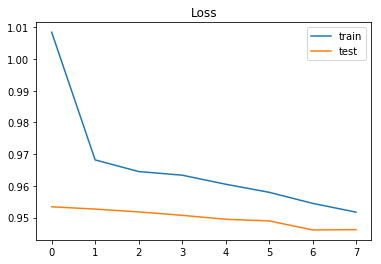

In [13]:
import matplotlib.pyplot as plt

plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

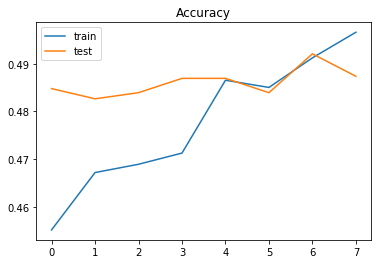

In [14]:
plt.title('Accuracy')
plt.plot(history.history['acc'], label='train')
plt.plot(history.history['val_acc'], label='test')
plt.legend()
plt.show()

In [12]:
pred = model.predict([X_numeric[test_idx], X_claim[test_idx], X_article[test_idx]])

pred_class = np.argmax(pred, axis=1)
pd.DataFrame(pred_class).to_pickle(os.path.join(PROJECT_DIR, "predictions\\predictions_bilstm.pkl"))